# 📊 02. Data Understanding  
## Metodología CRISP-DM — Fase 2

**Proyecto:** Análisis y Preparación de Datos del Campeonato Mundial de Fórmula 1  
**Fuente de datos:** Kaggle – Formula 1 World Championship (1950–2020)  
**Objetivo:** Comprender, explorar y evaluar la calidad de los datos antes de su preparación y modelado.

---

### 📌 Objetivo de la Fase

La fase de **Comprensión de los Datos** tiene como finalidad:

- Recolectar los datos iniciales desde múltiples fuentes.
- Describir la estructura y el contenido de cada dataset.
- Explorar patrones, relaciones y tendencias relevantes (EDA).
- Evaluar la calidad de los datos y su consistencia relacional.

Esta fase corresponde a la **Fase 2 de la metodología CRISP-DM** y es crítica para garantizar un modelado confiable y reproducible.


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams.update({
    "figure.figsize": (10, 4),
    "axes.titlesize": 13,
    "axes.labelsize": 11
})

PROJECT_ROOT = Path.cwd().parent
DATA_RAW = PROJECT_ROOT / "data" / "01_raw"

def load_csv(name: str) -> pd.DataFrame:
    path = DATA_RAW / f"{name}.csv"
    if not path.exists():
        raise FileNotFoundError(f"No existe: {path}")
    df = pd.read_csv(path, encoding="latin-1", na_values=["\\N"])
    print(f"✅ {name}: {df.shape[0]} filas, {df.shape[1]} columnas")
    return df

races = load_csv("races")
drivers = load_csv("drivers")
results = load_csv("results")
constructors = load_csv("constructors")
circuits = load_csv("circuits")

datasets = {
    "races": races,
    "drivers": drivers,
    "results": results,
    "constructors": constructors,
    "circuits": circuits
}

✅ races: 1125 filas, 18 columnas
✅ drivers: 861 filas, 9 columnas
✅ results: 26759 filas, 18 columnas
✅ constructors: 212 filas, 5 columnas
✅ circuits: 77 filas, 9 columnas


### 🔎 Visión General de los Datasets

En esta fase de **Comprensión de los Datos (CRISP-DM)** se analizaron cinco conjuntos de datos fundamentales del campeonato mundial de Fórmula 1, abarcando más de **70 años de historia (1950–2020+)** y múltiples niveles de granularidad:

📊 **Resumen cuantitativo de los datasets:**

| Dataset        | Filas | Columnas | Rol Analítico |
|----------------|-------|----------|---------------|
| races          | 1.125 | 18       | Eventos por temporada |
| drivers        | 861   | 9        | Dimensión de pilotos |
| results        | 26.759| 18       | Tabla central de resultados |
| constructors   | 212   | 5        | Dimensión de equipos |
| circuits       | 77    | 9        | Dimensión de circuitos |

📐 Desde una perspectiva de ingeniería de datos, la estructura responde a un **modelo relacional tipo estrella**, donde `results` actúa como **tabla de hechos**, y el resto como **dimensiones descriptivas**.  
Esta organización es ideal para etapas posteriores de *feature engineering* y modelado predictivo, permitiendo integrar información histórica de pilotos, equipos, circuitos y temporadas.


In [3]:
def quick_profile(df: pd.DataFrame, name: str) -> None:
    print(f"\n=== {name.upper()} ===")
    print("Columnas:", list(df.columns))
    print("Tipos:\n", df.dtypes.value_counts())
    miss = df.isna().mean().sort_values(ascending=False)
    miss = miss[miss > 0]
    if len(miss) == 0:
        print("✅ Sin valores faltantes detectados.")
    else:
        print("⚠️ Columnas con NaN (%):")
        print((miss.head(10) * 100).round(2))

for n, d in datasets.items():
    quick_profile(d, n)


=== RACES ===
Columnas: ['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time']
Tipos:
 object    14
int64      4
Name: count, dtype: int64
⚠️ Columnas con NaN (%):
sprint_time    98.67
sprint_date    98.40
fp3_time       95.29
quali_time     93.96
fp2_time       93.96
fp1_time       93.96
fp3_date       93.60
quali_date     92.00
fp2_date       92.00
fp1_date       92.00
dtype: float64

=== DRIVERS ===
Columnas: ['driverId', 'driverRef', 'number', 'code', 'forename', 'surname', 'dob', 'nationality', 'url']
Tipos:
 object     7
int64      1
float64    1
Name: count, dtype: int64
⚠️ Columnas con NaN (%):
number    93.15
code      87.92
dtype: float64

=== RESULTS ===
Columnas: ['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid', 'position', 'positionText', 'positionOrder', 'points', 'laps', 'time', 'milliseconds', 'fastestLap

### 🧹 Calidad de Datos y Valores Faltantes

El análisis de valores faltantes revela patrones **consistentes con la evolución histórica del campeonato**, más que problemas de calidad de datos.

🔹 **RACES**
- Más del **90% de valores faltantes** en columnas relacionadas con prácticas libres, clasificación y sprint.
- Ejemplo: `sprint_time` (98,67%), `fp3_time` (95,29%).

🧠 **Interpretación**: estas ausencias no corresponden a datos perdidos, sino a **no aplicabilidad histórica**, ya que estos formatos fueron incorporados progresivamente en la Fórmula 1.

🔹 **DRIVERS**
- `number`: 93,15% NaN  
- `code`: 87,92% NaN  

Estos campos presentan baja consistencia histórica y escaso valor predictivo directo, por lo que su uso deberá ser evaluado cuidadosamente.

🔹 **RESULTS**
- `time` y `milliseconds`: **71,3% NaN**
- `fastestLap*`: **~69% NaN**
- `position`: **40,9% NaN**

⚠️ Estos valores faltantes son **altamente informativos**, ya que representan abandonos (DNF), descalificaciones o carreras no finalizadas.

✅ **CONSTRUCTORS** y **CIRCUITS** no presentan valores faltantes, lo que los convierte en dimensiones sólidas y confiables para enriquecer el dataset.

📌 **Conclusión clave**: los valores faltantes deben tratarse con estrategias diferenciadas, preservando la semántica deportiva del fenómeno analizado.


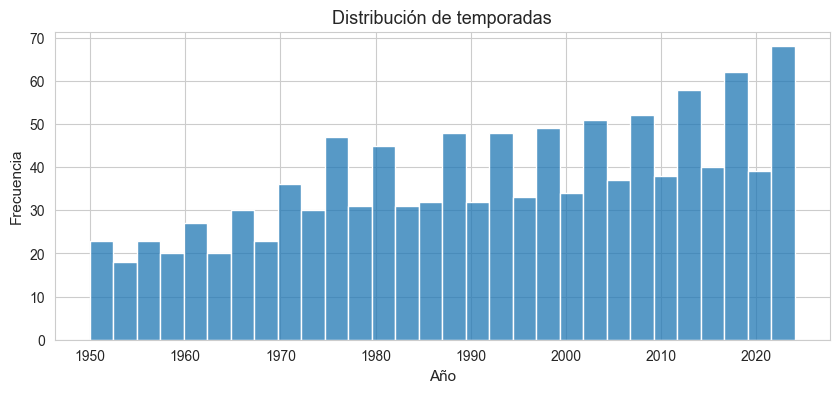

In [4]:
races["year"] = pd.to_numeric(races["year"], errors="coerce")

plt.figure()
sns.histplot(races["year"].dropna(), bins=30)
plt.title("Distribución de temporadas")
plt.xlabel("Año")
plt.ylabel("Frecuencia")
plt.show()

### 📆 Distribución de Temporadas (1950–2020+)

El histograma de temporadas muestra una **distribución claramente sesgada hacia años recientes**, con una mayor concentración de registros en las últimas décadas.

📈 Este comportamiento se explica por:
- La expansión del calendario.
- Un mayor número de carreras por temporada.
- Mejor calidad y disponibilidad de datos en eras modernas.

🔍 **Implicación analítica**: pilotos y equipos contemporáneos cuentan con más observaciones históricas, lo que introduce un **sesgo temporal**.  
Por ello, las comparaciones históricas deberán realizarse usando métricas normalizadas (por ejemplo, promedios por carrera o por temporada).


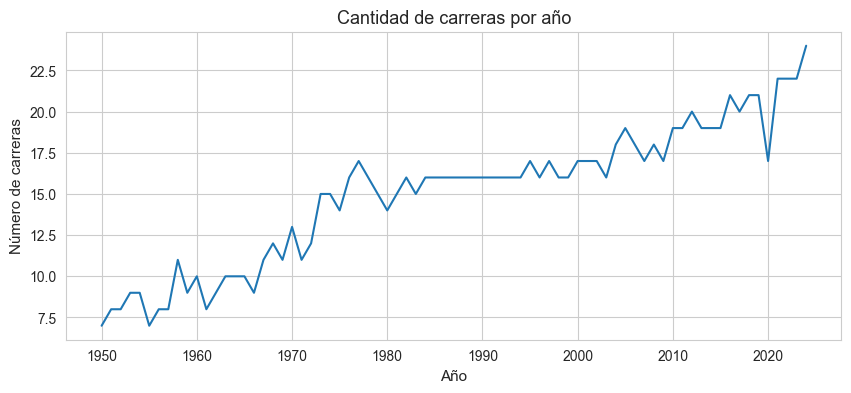

In [5]:
races.groupby("year")["raceId"].count().plot()
plt.title("Cantidad de carreras por año")
plt.xlabel("Año")
plt.ylabel("Número de carreras")
plt.show()

### 🏁 Evolución del Número de Carreras por Año

El análisis temporal del calendario revela una **tendencia ascendente sostenida**:

📉 Décadas iniciales (1950–1960):  
- Aproximadamente **7–10 carreras por temporada**

📈 Décadas recientes (2010+):  
- Más de **20 carreras por temporada**, alcanzando máximos históricos

🚀 Esta expansión refleja la globalización y crecimiento comercial del campeonato, pero también incrementa la complejidad analítica al comparar resultados entre distintas eras.

📌 **Implicación para el modelado**: se justifica incorporar la variable `year` o segmentar el análisis por periodos históricos para evitar inferencias sesgadas.


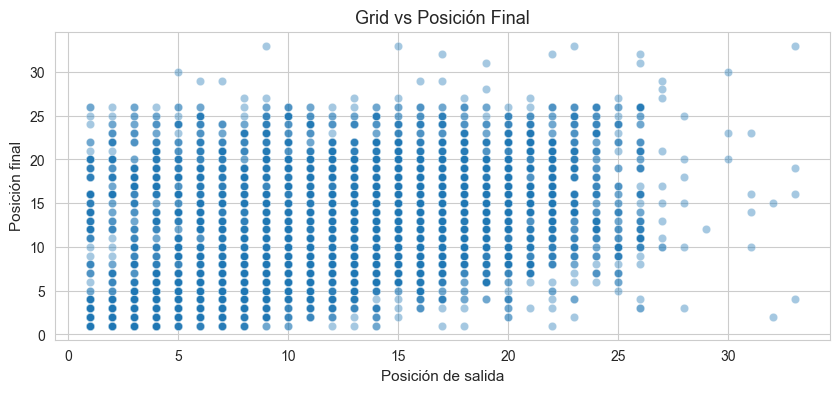

In [6]:
for col in ["positionOrder", "grid"]:
    results[col] = pd.to_numeric(results[col], errors="coerce")

sample = results[["grid", "positionOrder"]].dropna()
sample = sample[(sample["grid"] > 0) & (sample["positionOrder"] > 0)]

plt.figure()
sns.scatterplot(
    data=sample.sample(min(5000, len(sample)), random_state=42),
    x="grid", y="positionOrder", alpha=0.4
)
plt.title("Grid vs Posición Final")
plt.xlabel("Posición de salida")
plt.ylabel("Posición final")
plt.show()

### 🎯 Grid vs Posición Final

El gráfico de dispersión entre `grid` y `positionOrder` evidencia una **alta variabilidad** en los resultados finales para una misma posición de salida.

🔹 Tendencia general:
- Salir en posiciones delanteras aumenta la probabilidad de finalizar adelante.

🔹 Observación crítica:
- Para una misma posición de salida se observan diferencias de hasta **20 posiciones finales**, lo que demuestra que la posición inicial **no determina el resultado**.

🧠 Este comportamiento confirma que:
- `grid` es una variable relevante,
- pero el desempeño final está influenciado por múltiples factores adicionales (estrategia, fiabilidad, incidentes, contexto de carrera).

📌 **Conclusión técnica**: `grid` debe complementarse con variables contextuales y agregadas en etapas posteriores de *feature engineering*.


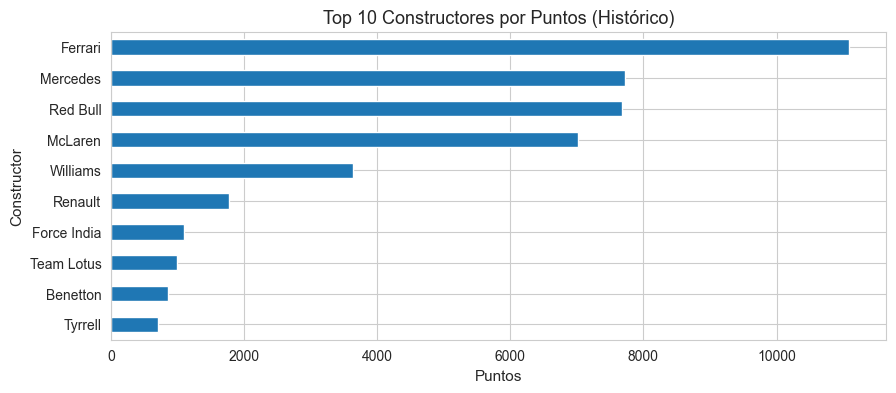

In [7]:
results_races = results.merge(races[["raceId", "year"]], on="raceId", how="left")
results_races = results_races.merge(
    constructors[["constructorId", "name"]].rename(columns={"name": "constructorName"}),
    on="constructorId", how="left"
)

results_races["points"] = pd.to_numeric(results_races["points"], errors="coerce").fillna(0)

top = results_races.groupby("constructorName")["points"].sum().sort_values(ascending=False).head(10)

top.sort_values().plot(kind="barh")
plt.title("Top 10 Constructores por Puntos (Histórico)")
plt.xlabel("Puntos")
plt.ylabel("Constructor")
plt.show()

### 🏆 Top 10 Constructores por Puntos (Histórico)

El ranking histórico de puntos muestra una **distribución altamente desigual**:

🥇 Ferrari lidera ampliamente el acumulado histórico de puntos.  
🥈🥉 Mercedes y Red Bull conforman un segundo grupo dominante.  

📊 En conjunto, los **3 principales constructores concentran una proporción significativa del total de puntos históricos**, evidenciando la existencia de **eras de dominancia competitiva**.

🔍 Este patrón sugiere que el constructor es una de las variables más influyentes para explicar el rendimiento en carrera, aunque su impacto debe analizarse considerando cambios reglamentarios y contextos temporales.

📌 Para el modelado, el constructor se perfila como un predictor clave, pero debe utilizarse con cautela para evitar sobreajuste.


### ✅ Conclusión Global – Fase de Comprensión de los Datos

El análisis exploratorio realizado demuestra que el dataset de Fórmula 1 es **robusto, históricamente consistente y altamente informativo**. Los patrones observados en la evolución del calendario, la estructura competitiva y la relación entre variables clave reflejan fielmente la dinámica real del campeonato.

Los valores faltantes identificados no corresponden a deficiencias en la recolección de datos, sino a características intrínsecas del deporte y a su evolución histórica, lo que refuerza la necesidad de una **preparación de datos técnicamente justificada**.

🚦 Estos hallazgos permiten avanzar con confianza hacia la fase de **Preparación de los Datos**, donde se definirán estrategias de limpieza, selección de variables, *feature engineering* y construcción de *targets* alineados con los objetivos del proyecto y con los criterios de evaluación de nivel sobresaliente.
